# OpSim -- simulation

## About

This notebook is for testing of the OpSim functionality.
An attempt was made to simplify code, so in most cases we
rely on the precalculated Sun trajectory and the solar
panel power output profile, loaded from files.

In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility

import numpy as np
import matplotlib.pyplot as plt
import simpy


In [2]:
# Load lusee and OpSim

import  lusee
from    nav        import * # includes luseepy
from    bms.parts  import * # Battery
from    bms.panels import *
from    bms.controller import *
from    bms.battery import *
# ----------------------------------------------------
print(f'''simpy version: {simpy.__version__}''')
print(f'''lusee version: {lusee.__version__}''')


simpy version: 4.0.2
lusee version: 1.2-dev


---

In the following, we have an option to read:
* _prefab data for the Sun trajectory_
* precalculated _panel power output profile_.


In [3]:
# Read the prefab data on sun trajectory
import os
from nav import Sun
print('Current directory:', os.getcwd())

mySun = Sun()

cachefile = '../data/2025-02-04_03-07.npy'
mySun.read(cachefile)
print(f'''Number of points read from the file {cachefile}: {mySun.N}''')

sun = mySun.xyz # altaz2xyz(mySun.alt, mySun.az)
hrs = mySun.hrsFromSunrise()


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Number of points read from the file ../data/2025-02-04_03-07.npy: 2993


In [4]:
import os
print('Current directory:', os.getcwd())
power_cachefile = '../data/2025-02-04_03-07_power.npy'
# with open(power_cachefile, 'rb') as f: pwr = np.load(f) #print(f'''Number of points read from the file {power_cachefile}: {pwr.size}''')

Panel.verbose = True
Panel.read_profile(power_cachefile)


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Loaded data from file "../data/2025-02-04_03-07_power.npy", number of points: 2993


---

Optionally, print out the power profile numbers to check if they make sense...

In [5]:
# To check the numerical values -- can convert to a Python list: a = list(pwr) print(*a, sep = ", ")
# Or, print power values with the MJD timestamps:
print(f'''Will attempt to access {mySun.N} points {Panel.profile}''')
for i in range(0, mySun.N):
    print("%5.3f: %5.3f" % (mySun.mjd[i], Panel.profile[i]))


Will attempt to access 2993 points [1.22536043 1.22404068 1.22271498 ... 0.         0.         0.        ]
60710.000: 1.225
60710.010: 1.224
60710.021: 1.223
60710.031: 1.221
60710.042: 1.220
60710.052: 1.219
60710.062: 1.217
60710.073: 1.216
60710.083: 1.215
60710.094: 1.213
60710.104: 1.212
60710.115: 1.211
60710.125: 1.209
60710.135: 1.208
60710.146: 1.206
60710.156: 1.205
60710.167: 1.204
60710.177: 1.202
60710.188: 1.201
60710.198: 1.199
60710.208: 1.198
60710.219: 1.196
60710.229: 1.195
60710.240: 1.194
60710.250: 1.192
60710.260: 1.191
60710.271: 1.189
60710.281: 1.188
60710.292: 1.186
60710.302: 1.185
60710.312: 1.183
60710.323: 1.182
60710.333: 1.180
60710.344: 1.179
60710.354: 1.177
60710.365: 1.176
60710.375: 1.174
60710.385: 1.173
60710.396: 1.171
60710.406: 1.170
60710.417: 1.168
60710.427: 1.166
60710.438: 1.165
60710.448: 1.163
60710.458: 1.162
60710.469: 1.160
60710.479: 1.159
60710.490: 1.157
60710.500: 1.155
60710.510: 1.154
60710.521: 1.152
60710.531: 1.151
60710.542

In [ ]:

plt.rcParams["figure.figsize"] = [8., 8.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, Panel.profile*250., color="red",    label="Panel power (a.u.)")
ax.set_xlabel('TIme (MJD)')
ax.plot(mySun.mjd, hrs, color="blue",    label="Hours before sunrise")
ax.plot(mySun.mjd, mySun.alt*250, color="yellow",  label="Altitude above horizon")


# --- plt.xlim(-100,400)
plt.grid(True)
plt.title("Power, hours before sunrise, and altitude")
plt.legend()

plt.show()

In [21]:
# Read device configuration
import yaml

device_file = '../config/devices.yml'
print(f'''Reading device profiles from the file "{'../config/devices.yml'}"''')
f = open(device_file, 'r')

device_data = yaml.load(f, Loader=yaml.FullLoader)
profiles    = device_data['devices']
print(profiles.keys())



Reading device profiles from the file "../config/devices.yml"
dict_keys(['controller', 'comms'])


Created a Battery with initial charge: 100.0, capacity: 1200.0
List added devices:
controller ON
comms OFF


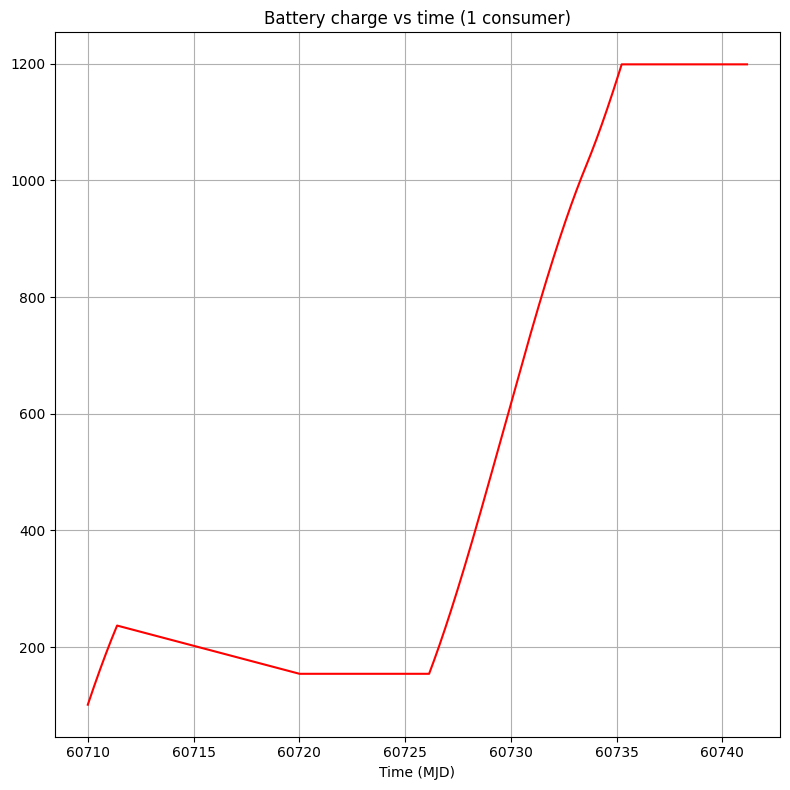

In [22]:
from    bms.battery     import *
from    bms.controller  import *
from    bms.parts       import *

env = simpy.Environment()

initial_charge, capacity = 100., 1200.

battery = Battery(env, initial_charge, capacity)

print(f'''Created a Battery with initial charge: {battery.level}, capacity: {battery.capacity}''')

mon = Monitor(mySun.N) # to define the discrete time axis
ctr = Controller(env, mySun.mjd, battery, mon)
ctr.add_all_panels(mySun)

for device_name in profiles.keys():
    device = Device(device_name, profiles[device_name])
    ctr.add_device(device)

ctr.set_device_state('controller', 'ON')

print('List added devices:')
for added_device in ctr.devices.keys():
        dvc = ctr.devices[added_device]
        print(dvc.name, dvc.state)


ctr.set_condition(mySun.condition)

env.process(ctr.run())
env.run(until=mySun.N)


plt.rcParams["figure.figsize"] = [8., 8.]
plt.rcParams["figure.autolayout"] = True
ax=plt.subplot()
ax.set_xlabel('Time (MJD)')

ax.plot(mySun.mjd, ctr.monitor.battery, color="red",    label="Panel power (a.u.)")

# --- plt.xlim(-100,400)
plt.grid(True)
plt.title("Battery charge vs time (1 consumer)")
plt.show()



